In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
# -*- coding: utf-8 -*-
"""
Demo code

@author: Denis Tome'

"""
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from base import SetType
import multiprocessing
from mocap import Mocap
from utils import config, ConsoleLogger
from utils import evaluate, io
from model import TempModel
from model_xregopose import xR_egoposemodel
from model_mo2cap2 import mo2cap_ours
from tqdm import tqdm
import os

LOGGER = ConsoleLogger("Main")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms.functional import to_pil_image
import numpy as np
import platform
import matplotlib.pyplot as plt
from utils import config
import wandb
split_token = '/' if 'Linux' in platform.platform() else '\\'

In [3]:

def joint_3d_viewer(input_images, joints, labels, infos):
	colors = plt.cm.jet(np.linspace(0, 1, 16))
	temp_input_images = input_images.clone().detach().cpu()
	temp_labels = labels.clone().detach().cpu() 
	temp_joints = joints.clone().detach().cpu() 
	fig,ax = plt.subplots(len(labels),3,figsize=(10,70),subplot_kw={"projection":"3d"})
	for i in range(len(labels)):
		rows, cols, start, stop = ax[i][0].get_subplotspec().get_geometry()
		ax[i][0].remove()
		ax[i][0] = fig.add_subplot(rows,cols,start+1)
	
	for i,(input_image, joint, label, info) in enumerate(zip(temp_input_images, temp_joints, temp_labels, infos)):
		input_image=to_pil_image(input_image*.5+.5)

		for j,(k,v) in enumerate(config.skel_16.items()):
			if v['parent']:
				p_idx = config.skel_16[v['parent']]['jid']
				idx = v['jid']
				pred_joint_line_x=[joint[idx,0],joint[p_idx,0]]
				pred_joint_line_y=[joint[idx,1],joint[p_idx,1]]
				pred_joint_line_z=[joint[idx,2],joint[p_idx,2]]
				# ax[i][1].plot(pred_joint_line_x, pred_joint_line_y, pred_joint_line_z,color=colors[j])
				ax[i][1].plot(pred_joint_line_x, pred_joint_line_y, pred_joint_line_z,color='r')
				label_joint_line_x=[label[idx,0],label[p_idx,0]]
				label_joint_line_y=[label[idx,1],label[p_idx,1]]
				label_joint_line_z=[label[idx,2],label[p_idx,2]] 
				# ax[i][2].plot(label_joint_line_x,label_joint_line_y, label_joint_line_z,color=colors[j])
				ax[i][1].plot(label_joint_line_x,label_joint_line_y, label_joint_line_z,color='g')
		
		ax[i][0].set_aspect('equal')
		ax[i][1].set_aspect('equal')
		ax[i][2].set_aspect('equal')
		ax[i][1].view_init(-30,60,180)
		ax[i][2].view_init(-30,60,180)
		ax[i][1].set_xlabel('x')
		ax[i][1].set_ylabel('y')
		ax[i][1].set_zlabel('z')
		ax[i][2].set_ylabel('y')
		ax[i][2].set_xlabel('x')
		ax[i][2].set_zlabel('z')
		
		ax[i][0].imshow(input_image)

		ax[i][0].set_title(info.split(split_token)[-1])
		ax[i][1].set_title('pred_3d_joint')
		ax[i][2].set_title('3d_joint_GT')
	# plt.show()
	return fig


def heatmap_viewer(input_images, heatmaps, labels, infos):
	temp_input_images = input_images.clone().detach()
	temp_heatmaps = heatmaps.clone().detach().cpu()
	temp_labels = labels.clone().detach().cpu()
	fig, ax = plt.subplots(len(labels),3,figsize=(10,70))

	for i,(input_image, heatmap, label, info) in enumerate(zip(temp_input_images, temp_heatmaps, temp_labels, infos)):


		input_image = to_pil_image(input_image*.5+.5)
		total_heatmap = torch.zeros(heatmap.shape[1:])
		for j in range(len(heatmap)):
			total_heatmap += heatmap[j,:,:]

		total_label = torch.zeros(heatmap.shape[1:])
		for j in range(len(label)):
			total_label += label[j,:,:]

		ax[i][0].set_title(info.split(split_token)[-1])
		ax[i][0].imshow(input_image)
		ax[i][1].set_title('pred_heatmap')
		ax[i][1].imshow(total_heatmap)
		ax[i][2].set_title('heatmap_GT')
		ax[i][2].imshow(total_label)

	# plt.show()

	return fig 


def silhouette_viewer(input_images, pred_silhouette, labels, infos):
	temp_input_images = input_images.clone().detach()
	temp_silhouette = pred_silhouette.clone().detach().cpu()
	temp_labels = labels.clone().detach().cpu()
	fig, ax = plt.subplots(len(labels),3,figsize=(10,70))

	for i,(input_image, silhouette, label, info) in enumerate(zip(temp_input_images, temp_silhouette, temp_labels, infos)):
		input_image=to_pil_image(input_image*.5+.5)
		silhouette = (silhouette>.5).float()
		silhouette=to_pil_image(silhouette)
		label=to_pil_image(label)
		ax[i][0].set_title(info.split(split_token)[-1])
		ax[i][0].imshow(input_image )
		ax[i][1].set_title('pred_silhouette')
		ax[i][1].imshow(silhouette)
		ax[i][2].set_title('silhouette_GT')
		ax[i][2].imshow(label)



	# plt.show()

	return fig 

def depth_viewer(input_images, features, labels, infos):
	temp_input_images=input_images.clone().detach().cpu()
	temp_features=features.clone().detach().cpu()
	temp_labels=labels.clone().detach().cpu()
	fig,ax = plt.subplots(len(labels),3,figsize=(10, 70))

	for i,(input_image, feature, label,info) in enumerate(zip(temp_input_images, temp_features, temp_labels,infos)):

		input_image=to_pil_image(input_image*.5+.5)
		feature=to_pil_image(feature)
		label=to_pil_image(label)
		ax[i][0].set_title(info.split(split_token)[-1])
		ax[i][0].imshow(input_image )
		ax[i][1].set_title('pred_depthmap')
		ax[i][1].imshow(feature)
		ax[i][2].set_title('depth_GT')
		ax[i][2].imshow(label)


	# plt.show()

	return fig

In [4]:

def main(model_path=None,output_path=None):
	"""Main"""

	LOGGER.info('Starting demo...')
	# wandb.init(project="2d to 3d", entity="vhehduatks")
	# ------------------- Data loader -------------------


	# let's load data from validation set as example
	data = Mocap(
		'/dataset/data/Dataset/TestSet',
		SetType.VAL,
		)
	data_loader = DataLoader(
		data,
		batch_size=16,
		# num_workers=(multiprocessing.cpu_count() // 3) * 2,
		num_workers=0,
		shuffle=True)

	# ------------------- Evaluation -------------------

	eval_body = evaluate.EvalBody()
	eval_upper = evaluate.EvalUpperBody()
	eval_lower = evaluate.EvalLowerBody()

	# ------------------- Read dataset frames -------------------

	model = TempModel(pretrained_path=model_path).to(device)
	model = torch.nn.DataParallel(model,device_ids=[0,1])
	model.eval()

	for it, test_batch in enumerate(tqdm(data_loader)):
		image = test_batch['image'].cuda()
		image_zoom = test_batch['image_zoom'].cuda()
		p3d = test_batch['joints_3d_cam']
		action = test_batch['action']

		joint_3d_labels = test_batch['joints_3d_cam'].to(device)
		infos = test_batch['info']
		heatmap_labels = test_batch['heatmap'].to(device)
		depth_labels = test_batch['depth'].to(device)
		silhouette_labels = test_batch['silhouette'].to(device)

		inputs = {
			'image':image,
			# 'image_zoom' : image_zoom,
			}
		# LOGGER.info('Iteration: {}'.format(it))
		# LOGGER.info('Images: {}'.format(img.shape))
		# LOGGER.info('p2ds: {}'.format(p2d.shape))
		# LOGGER.info('p3ds: {}'.format(p3d.shape))
		# LOGGER.info('Actions: {}'.format(action))

		# -----------------------------------------------------------
		pred_dict = model(inputs)
		# -----------------------------------------------------------

		# TODO: replace p3d_hat with model preditions
		p3d_hat = pred_dict['pred_pose']

		# Evaluate results using different evaluation metrices
		y_output = p3d_hat.data.cpu().numpy() * 1000
		y_target = p3d.data.cpu().numpy() * 1000

		eval_body.eval(y_output, y_target, action)
		eval_upper.eval(y_output, y_target, action)
		eval_lower.eval(y_output, y_target, action)
		if (it+1)%200==0:
			print({'FullBody': eval_body.get_results(),
		   'UpperBody': eval_upper.get_results(),
		   'LowerBody': eval_lower.get_results()})
			# break

		# TODO: remove break
		if (it + 1) % 1 == 0:
			fig_dict = {
				'depthmap_fig' : depth_viewer(inputs['image'],pred_dict['depthmap'],depth_labels,infos),
				'heatmap_fig' : heatmap_viewer(inputs['image'],pred_dict['heatmap'],heatmap_labels,infos),
				'joint_3d_fig' : joint_3d_viewer(inputs['image'],pred_dict['pred_pose'],joint_3d_labels,infos),
				'silhouette_fig' : silhouette_viewer(inputs['image'],pred_dict['silhouette'],silhouette_labels,infos),
			}
			wandb.log({
				"test/depthmap_fig":[wandb.Image(fig_dict['depthmap_fig'])],
				"test/heatmap_fig":[wandb.Image(fig_dict['heatmap_fig'])],
				"test/joint_3d_fig":[wandb.Image(fig_dict['joint_3d_fig'])],
				"test/silhouette_fig":[wandb.Image(fig_dict['silhouette_fig'])],
			})
			for key,val in fig_dict.items():
					plt.close(val)
	# ------------------- Save results -------------------

	LOGGER.info('Saving evaluation results...')
	res = {'FullBody': eval_body.get_results(),
		   'UpperBody': eval_upper.get_results(),
		   'LowerBody': eval_lower.get_results()}

	io.write_json(output_path, res)

	LOGGER.info('Done.')
	wandb.finish()

In [5]:
import glob
path_ =sorted(glob.glob('/workspace/2d_to_3d/apps/exp808'+'/*'))
path_

['/workspace/2d_to_3d/apps/exp808/0.pth',
 '/workspace/2d_to_3d/apps/exp808/1.pth',
 '/workspace/2d_to_3d/apps/exp808/2.pth',
 '/workspace/2d_to_3d/apps/exp808/3.pth',
 '/workspace/2d_to_3d/apps/exp808/4.pth',
 '/workspace/2d_to_3d/apps/exp808/5.pth',
 '/workspace/2d_to_3d/apps/exp808/6.pth',
 '/workspace/2d_to_3d/apps/exp808/7.pth',
 '/workspace/2d_to_3d/apps/exp808/8.pth',
 '/workspace/2d_to_3d/apps/exp808/9.pth',
 '/workspace/2d_to_3d/apps/exp808/best.pth']

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()
raise

RuntimeError: No active exception to reraise

05:42:07 [INFO] Main: Starting demo...
  0%|          | 0/5352 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
  0%|          | 0/5352 [11:27<?, ?it/s]


RuntimeError: The size of tensor a (47) must match the size of tensor b (32) at non-singleton dimension 1

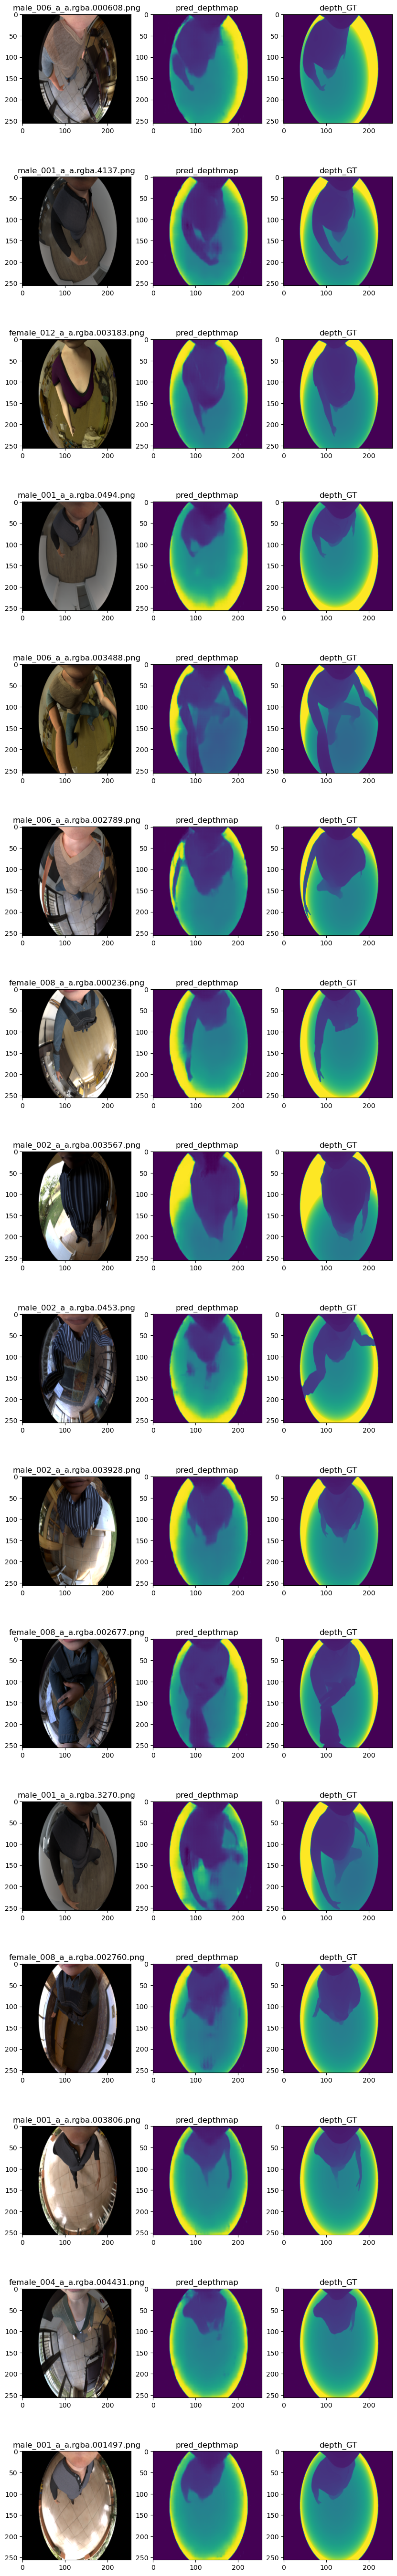

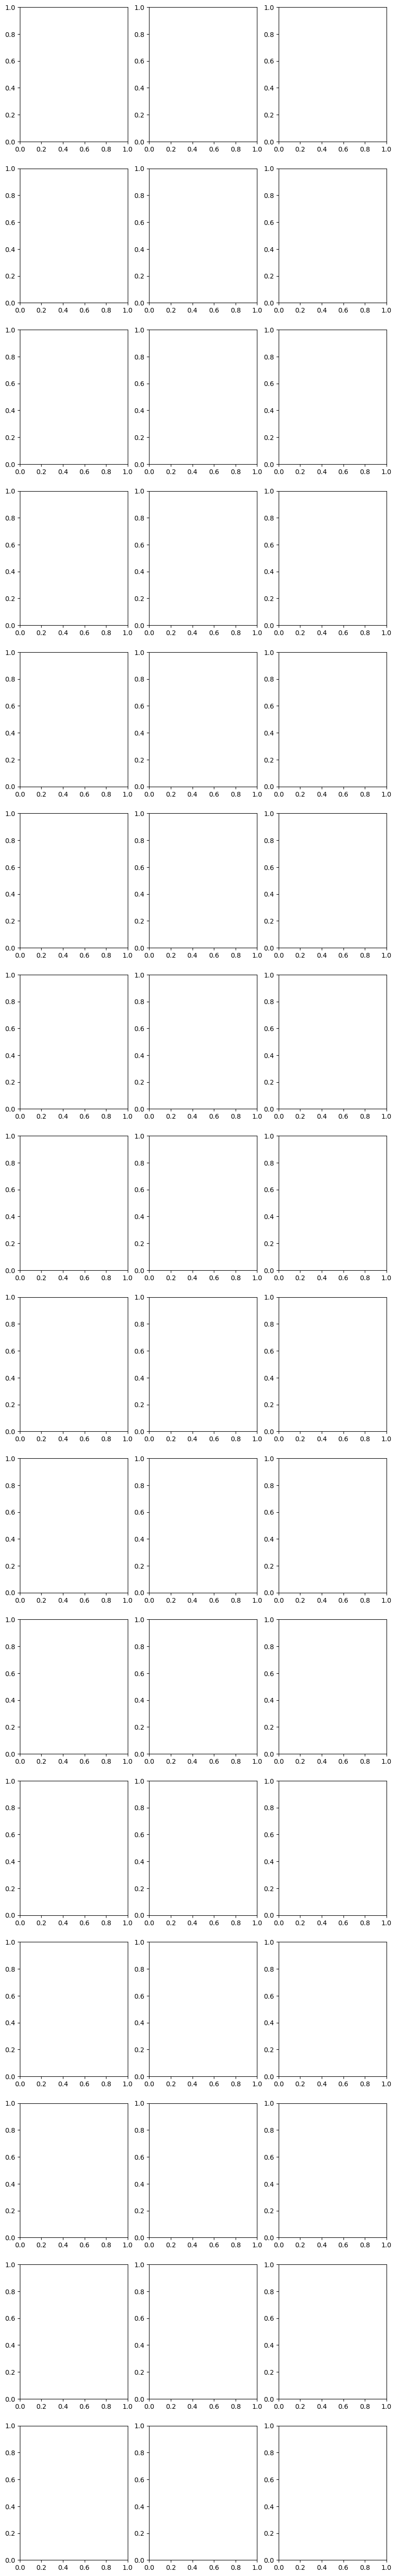

In [7]:
for i,p in enumerate(path_):
	_path = f'/workspace/2d_to_3d/apps/eval/ours_depth_sil_sep'
	_name = f'baseline808_{i}.json'
	if not os.path.exists(_path):
		os.makedirs(_path)

	main(model_path=p,output_path=os.path.join(_path,_name))